In [23]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments


In [25]:
# from PIL import Image
# from transformers import DetrImageProcessor
# from transformers import TableTransformerForObjectDetection

# import torch
# import matplotlib.pyplot as plt
# import os
# import psutil
# import time
# from transformers import DetrFeatureExtractor,DetrImageProcessor
# feature_extractor = DetrFeatureExtractor()
# import pandas as pd
# import pytesseract

In [26]:
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
from huggingface_hub import hf_hub_download
from PIL import Image
from transformers import DetrFeatureExtractor, DetrImageProcessor
from transformers import TableTransformerForObjectDetection
from torchvision import transforms
import torch
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")

In [27]:
# downloading one sample image
# file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
file_path = "image_extracts/Accenture__Original__MSA Completely Signed Accenture_images/page73.jpeg"

In [28]:
from PIL import Image
from PIL import ImageOps
import numpy as np

In [34]:
def crop_whitespaces(image, padding=5, plot=False):
    """
    Crop the image to remove whitespace around the content.

    Args:
    - file_path (str): Path to the image file.
    - padding (int): Padding around the content to keep.

    Returns:
    - PIL.Image: Cropped image.
    """
    padding = 5
    padding = np.asarray([-1 * padding, -1 * padding, padding, padding])

    # invert image (so that white is 0)
    invert_im = ImageOps.invert(image)
    imageBox = invert_im.getbbox()
    imageBox = tuple(np.asarray(imageBox) + padding)

    cropped_image = image.crop(imageBox)

    if plot:
        width, height = cropped_image.size
        fig, ax = plt.subplots(1, figsize=(12, 12))
        plt.title("Cropped Image")
        img = cropped_image.resize((int(width * 0.5), int(height * 0.5)))
        ax.imshow(img)
        plt.axis("off")
        plt.show()

    return cropped_image

In [35]:
def read_images(file_path, plot=True, crop_whites=True):
    """Read image from file path and optionally display it."""
    image = Image.open(file_path).convert("RGB")
    if plot:
        img_resized = image.resize((int(image.width * 0.5), int(image.height * 0.5)))
        plt.figure(figsize=(12, 12))
        plt.title("Original Image")
        plt.imshow(img_resized)
        plt.axis("off")
        plt.show()

    if crop_whites:
        image = crop_whitespaces(image, plot=plot)

    return image

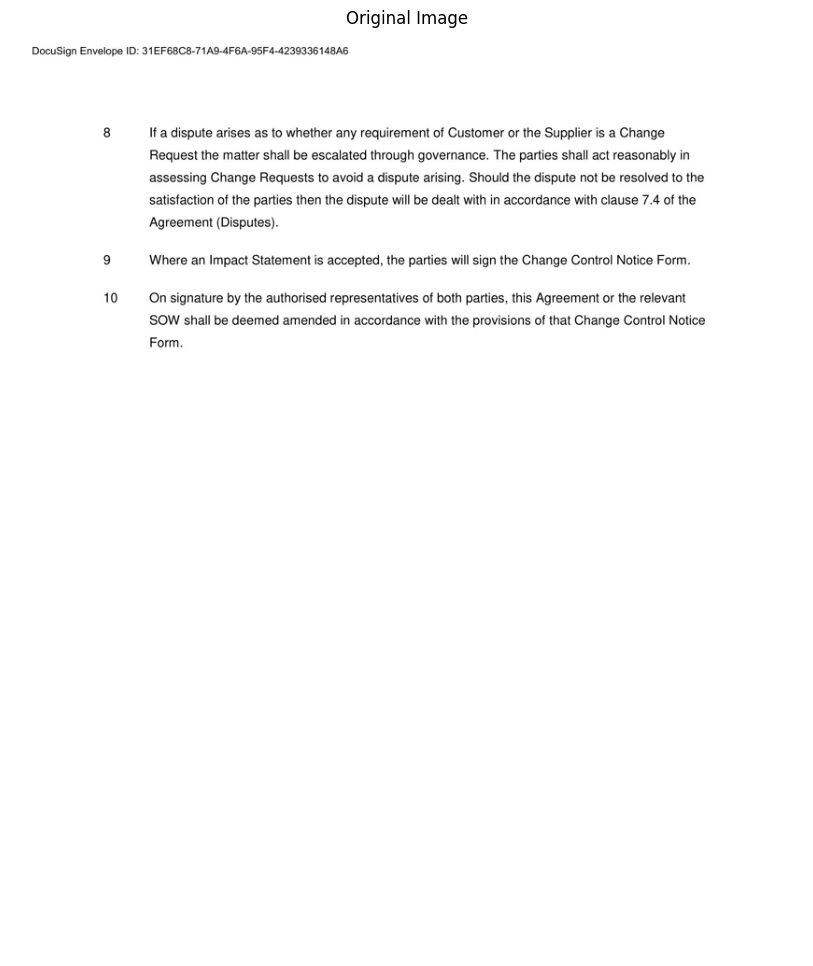

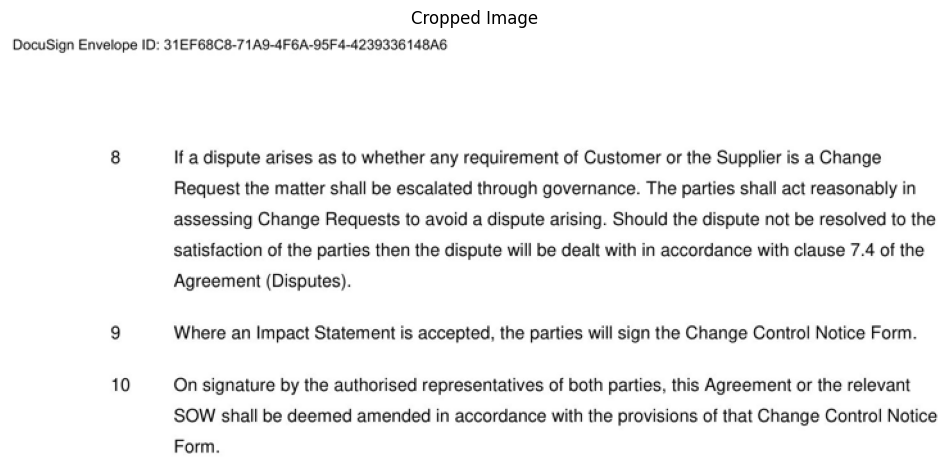

In [36]:
image = read_images(file_path, plot=True, crop_whites=True)

In [219]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
# print(device)

In [220]:
detection_model_name = "microsoft/table-transformer-detection"

In [221]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(detection_model_name)
model = AutoModelForObjectDetection.from_pretrained(
    detection_model_name, revision="no_timm"
)
model.to(device)

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [222]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [223]:
class MaxResize(object):
    """Resize the image so that the maximum size is equal to max_size"""

    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )

        return resized_image


detection_transform = transforms.Compose(
    [
        MaxResize(1000),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [224]:
# # this the manual way of doing the image pre-processing

# pixel_values = detection_transform(image).unsqueeze(0)
# pixel_values = pixel_values.to(device)
# print(pixel_values.shape)

In [225]:
pixel_values_c = image_processor(cropped_image, return_tensors="pt")

In [226]:
pixel_values_c["pixel_values"].shape
# pixel_values_c['pixel_mask'].shape

torch.Size([1, 3, 800, 581])

In [227]:
with torch.no_grad():
    outputs = model(**pixel_values_c)

In [228]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    """Convert bounding boxes from [x, y, w, h] format to [x1, y1, x2, y2] format."""
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    """Rescale bounding boxes from [0, 1] to image size."""
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    """Convert model outputs to objects list"""
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append(
                {
                    "label": class_label,
                    "score": float(score),
                    "bbox": [float(elem) for elem in bbox],
                }
            )

    return objects

In [229]:
objects = outputs_to_objects(outputs, cropped_image.size, id2label)

In [230]:
objects

[{'label': 'table',
  'score': 0.9978006482124329,
  'bbox': [171.93777465820312,
   757.7725830078125,
   1401.8194580078125,
   1936.2735595703125]}]

In [231]:
target_sizes = torch.tensor([cropped_image.size[::-1]])
results = image_processor.post_process_object_detection(
    outputs, threshold=0.7, target_sizes=target_sizes
)[0]

In [232]:
results

{'scores': tensor([0.9978]),
 'labels': tensor([0]),
 'boxes': tensor([[ 171.9378,  757.7726, 1401.8195, 1936.2736]])}

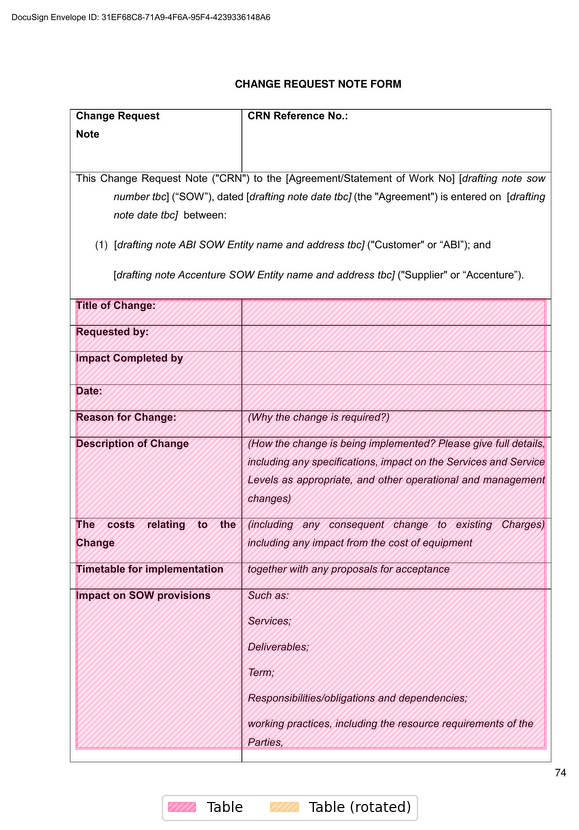

In [233]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io

    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table["bbox"]

        if det_table["label"] == "table":
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch = "//////"
        elif det_table["label"] == "table rotated":
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch = "//////"
        else:
            continue

        rect = patches.Rectangle(
            bbox[:2],
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=linewidth,
            edgecolor="none",
            facecolor=facecolor,
            alpha=0.1,
        )
        ax.add_patch(rect)
        rect = patches.Rectangle(
            bbox[:2],
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=linewidth,
            edgecolor=edgecolor,
            facecolor="none",
            linestyle="-",
            alpha=alpha,
        )
        ax.add_patch(rect)
        rect = patches.Rectangle(
            bbox[:2],
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=0,
            edgecolor=edgecolor,
            facecolor="none",
            linestyle="-",
            hatch=hatch,
            alpha=0.2,
        )
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [
        Patch(
            facecolor=(1, 0, 0.45),
            edgecolor=(1, 0, 0.45),
            label="Table",
            hatch="//////",
            alpha=0.3,
        ),
        Patch(
            facecolor=(0.95, 0.6, 0.1),
            edgecolor=(0.95, 0.6, 0.1),
            label="Table (rotated)",
            hatch="//////",
            alpha=0.3,
        ),
    ]
    plt.legend(
        handles=legend_elements,
        bbox_to_anchor=(0.5, -0.02),
        loc="upper center",
        borderaxespad=0,
        fontsize=10,
        ncol=2,
    )
    plt.gcf().set_size_inches(10, 10)
    plt.axis("off")

    if out_path is not None:
        plt.savefig(out_path, bbox_inches="tight", dpi=150)

    return fig


fig = visualize_detected_tables(cropped_image, objects)

In [234]:
def contains_non_white_pixels(image, bbox):
    """Check if a bounding box region contains non-white pixels."""
    xmin, ymin, xmax, ymax = map(int, bbox)
    cropped_img = image.crop((xmin, ymin, xmax, ymax))
    # plt.imshow(cropped_img)
    # plt.axis("off")
    # plt.show()
    pixels = cropped_img.getdata()
    non_white_pixels = any(pixel != (255, 255, 255) for pixel in pixels)

    return non_white_pixels


def get_table_bbox(results, detection_model):
    """Get table bounding box coordinates."""
    tables_coordinates = []

    for score, label, box in zip(
        results["scores"], results["labels"], results["boxes"]
    ):
        box = [round(i.item(), 2) for i in box]
        if contains_non_white_pixels(image, box):
            table_dict = {
                "xmin": box[0],
                "ymin": box[1],
                "xmax": box[2],
                "ymax": box[3],
            }
            tables_coordinates.append(table_dict)
            print(
                f"Detected {detection_model.config.id2label[label.item()]} with confidence "
                f"{round(score.item(), 3)} at location {box}"
            )

    return tables_coordinates

In [235]:
get_table_bbox(results, model)

Detected table with confidence 0.998 at location [171.94, 757.77, 1401.82, 1936.27]


[{'xmin': 171.94, 'ymin': 757.77, 'xmax': 1401.82, 'ymax': 1936.27}]